<a href="https://colab.research.google.com/github/priyankagupta0/Text-generation-using-tweets/blob/main/TwitterTextGeration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assessment Project Brief:  Data Science (NLP) internship

**Task** : Text Generation

In this assignment, our task is focused on text generation using machine learning techniques. We will be working with a dataset of tweets from a specific user and our goal is to build a machine learning model that can generate new tweets based on the patterns and characteristics of the user's existing tweets.

In [ ]:
# importing all the required modules.
!pip install keras_preprocessing keras
import numpy as np
import pandas as pd 
import re

# Neural Net Preprocessing
import tensorflow as tf
import keras_preprocessing
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras_preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 748.6 kB/s eta 0:00:00


In [ ]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Importing the dataset: [dataset](https://www.kaggle.com/datasets/shivammehta007/trump-tweetcsv)

About dataset: Donald Trump Tweets Drumped About Russia

In [ ]:
import pandas as pd

dataset = pd.read_csv('task3_corpus.csv')
print('Number of training tweets: ', dataset.shape[0])

Number of training tweets:  341


In [ ]:
dataset.head()

,text
0,Russia has informed us that they have removed ...
1,Hearing word that Russia Syria and to a lesser...
2,Sean Davis The Federalist: “Mueller proved his...
3,Russia Russia Russia! That’s all you heard at ...
4,Russia Russia Russia! That’s all you heard at ...


In [ ]:
print(dataset['text'][0])

Russia has informed us that they have removed most of their people from Venezuela.


In [ ]:
dataset.isnull().sum()

text    0
dtype: int64

In [ ]:
dataset = dataset[['text']]
dataset

,text
0,Russia has informed us that they have removed ...
1,Hearing word that Russia Syria and to a lesser...
2,Sean Davis The Federalist: “Mueller proved his...
3,Russia Russia Russia! That’s all you heard at ...
4,Russia Russia Russia! That’s all you heard at ...
...,...
336,Crimea was TAKEN by Russia during the Obama Ad...
337,Information is being illegally given to the fa...
338,This Russian connection non-sense is merely an...
339,I don't know Putin have no deals in Russia and...


In [ ]:
dataset['word_count'] = dataset['text'].str.split().str.len()
average_word_count = dataset['word_count'].mean()

In [ ]:
dataset

,text,word_count
0,russia informed us removed people venezuela,6
1,hearing word russia syria lesser extent iran b...,23
2,sean davis federalist mueller proved entire op...,21
3,russia russia russia heard beginning witch hun...,22
4,russia russia russia heard beginning witch hun...,22
...,...,...
336,crimea taken russia obama administration obama...,8
337,information illegally given failing nytimes am...,13
338,russian connection non sense merely attempt co...,14
339,know putin deals russia haters going crazy yet...,15


In [ ]:
average_word_count

20.466275659824046

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    341 non-null    object
dtypes: object(1)
memory usage: 2.8+ KB


Looks like we have a nasty data in text. Because in general we use lot of punctuations and other words without any contextual meaning. It have no value as feature to the model we are training. So we need to get rid of them.

### **Text Preprocessing**
Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model we cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods.

### Stemming/Lemmatization
Stemming and lemmatization aim to reduce word forms, including inflections and derivationally related words, to a common base form. Stemming involves cutting word endings to achieve accuracy, often removing derivational affixes. Lemmatization focuses on proper handling using vocabulary and morphological analysis, aiming to remove only inflectional endings and return the base form of a word.
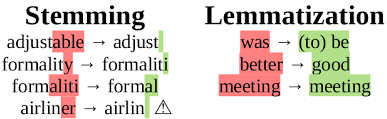

### Hyperlinks and Mentions
Twitter allows users to mention others by their usernames and share internet links through hyperlinks in tweets, resulting in a significant presence of hyperlinks and user mentions.
Example:
*   User Mentions: e.g., @priyankag, @newyork
*   Hyperlinks: e.g., https://priyankagupta.me, https://tensorflow.org

### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are: i, me, did etc



In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
dataset.text = dataset.text.apply(lambda x: preprocess(x))

In [ ]:
dataset

,text
0,russia informed us removed people venezuela
1,hearing word russia syria lesser extent iran b...
2,sean davis federalist mueller proved entire op...
3,russia russia russia heard beginning witch hun...
4,russia russia russia heard beginning witch hun...
...,...
336,crimea taken russia obama administration obama...
337,information illegally given failing nytimes am...
338,russian connection non sense merely attempt co...
339,know putin deals russia haters going crazy yet...


The first step to training any NLP model is the tokenization of words. Here we use the Keras Tokenizer, which does the following:



*   Removes punctuation
*   Sets all text to lower case
*   Splits the words up into individual elements in a list, then assigns a 
unique integer to each word
*   Replaces all instances of that word with the integer.

Tokenization is necessary for preparing data for embedding layer.












 The following code tokenizes the text data using the Tokenizer class, converts the corpus into input-output sequences, and returns the sequences along with the total number of words and index-to-word mapping.

In [ ]:
# creating a tokenizer object
tokenizer = Tokenizer()
def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words, tokenizer.index_word

inp_sequences, total_words, idx2word = get_sequence_of_tokens(dataset.text)

The follwoing function pads the input sequences to have the same length, splits them into predictors and labels, and returns the predictors, labels, and maximum sequence length. The code then calls this function with the inp_sequences obtained from a previous step.

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max(map(len,input_sequences))
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [ ]:
predictors.shape, label.shape

((6638, 39), (6638,))

In [ ]:
total_words


1931

In [ ]:
# Wrap data in Dataset objects.
train_data = tf.data.Dataset.from_tensor_slices((predictors, label))
# The batch size must now be set on the Dataset objects.
batch_size = 512
train_data = train_data.batch(batch_size)
train_data = train_data.shuffle(buffer_size=train_data.cardinality(), reshuffle_each_iteration=True)

In [ ]:
len(train_data)


13

The generator model consists of an Embedding layer, followed by an LSTM layer, and finally a Dense layer. It takes a sequence of input tokens, processes them through the layers, and produces a probability distribution over the vocabulary for generating the next word in a sequence.

In [ ]:
generator = Sequential([
    tf.keras.layers.Embedding(total_words,8,input_length=max_sequence_len-1),
    tf.keras.layers.LSTM(128,activation='tanh'),
    tf.keras.layers.Dense(total_words,activation='softmax')
])

In [ ]:
print(generator.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 8)             15448     
                                                                 
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dense (Dense)               (None, 1931)              249099    
                                                                 
Total params: 334,691
Trainable params: 334,691
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=SparseCategoricalCrossentropy())


## Model Training

In [ ]:
generator.fit(
    train_data,
    epochs=500
)

Epoch 1/500
13/13 [==============================] - 4s 136ms/step - loss: 3.3450
Epoch 2/500
13/13 [==============================] - 0s 12ms/step - loss: 3.2701
Epoch 3/500
13/13 [==============================] - 0s 10ms/step - loss: 3.2467
Epoch 4/500
13/13 [==============================] - 0s 9ms/step - loss: 3.2198
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 3.1963
Epoch 6/500
13/13 [==============================] - 0s 8ms/step - loss: 3.1768
Epoch 7/500
13/13 [==============================] - 0s 8ms/step - loss: 3.1595
Epoch 8/500
13/13 [==============================] - 0s 8ms/step - loss: 3.1396
Epoch 9/500
13/13 [==============================] - 0s 8ms/step - loss: 3.1187
Epoch 10/500
13/13 [==============================] - 0s 8ms/step - loss: 3.0989
Epoch 11/500
13/13 [==============================] - 0s 8ms/step - loss: 3.0771
Epoch 12/500
13/13 [==============================] - 0s 8ms/step - loss: 3.0651
Epoch 13/500
13/13 [=============

In [ ]:
generator.save('tweets.h5')

Here, the generate_text function takes a seed text, generates the specified number of next words using the trained model, and returns the generated text. Note that the code assumes the presence of a preprocess function and specific data preprocessing steps specific to your implementation.

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    seed_test = preprocess(seed_text)
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predict_data = tf.data.Dataset.from_tensor_slices((token_list,))
        batch_size = 1
        predict_data = predict_data.batch(batch_size)
        predicted = model.predict(predict_data,verbose=0)
        predicted = np.argmax(predicted,axis=1)
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text

## Results

In [ ]:
print(generate_text('putin',20,generator,max_sequence_len))

putin russia time amp dangerous low thank congress people even give us hcare us biased would deutschebank commitment little nato may


In [ ]:
print(generate_text('Gun',13,generator,max_sequence_len))

Gun recognized russian meddling many times thank foxandfriends foxnews actually showing clips fake news
